# Generate a Set of Synthetic Data
Use the initial parameters to create synthetic data.

The capacity will decrease and the resistance will increase following [a bilinear model](https://www.sciencedirect.com/science/article/pii/S0378775322007303) such that the inflection point and point at which the capacity reaches a failure point are approximately 1000 cycles.

**TODO (wardlt)**
- Make cycle stress relate to the life, though I would advocate for using NREL's synthetic models rather than inventing one

In [1]:
%matplotlib inline
from moirae.models.ecm import EquivalentCircuitModel as ECM
from moirae.models.ecm.components import Resistance, OpenCircuitVoltage, MaxTheoreticalCapacity, ReferenceOCV
from moirae.models.ecm import ECMASOH, ECMTransientVector, ECMInput, ECMMeasurement
from moirae.simulator import Simulator
from moirae.interface import run_online_estimate
from moirae import __version__ as moirae_version
from matplotlib import pyplot as plt
from batdata.data import BatteryDataset
from batdata.schemas.modeling import ModelMetadata
from scipy import stats
from shutil import copyfileobj
from hashlib import sha256
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import requests

General Configuration

In [2]:
output_dir = Path('synth-data')

Parameter estimation configuration

In [3]:
initial_asoh = ECMASOH.model_validate_json(Path('initial-asoh.json').read_text())

Simulation configuration

In [4]:
timestep_duration: float = 5.  # Time between measurements in seconds

Degredation variation

In [5]:
knee_cycles = stats.multivariate_normal(mean=[1000, 1000], cov=[[150, 50], [50, 150]])  # Distribution of knee point for capacity and resistance. Ensure they are similar
knee_capacity = stats.expon(scale=0.08)  # Capacity loss to the knee.
knee_resistance = stats.expon(scale=1.1)  # Resistance gain to the knee
post_knee_cycles = stats.expon(loc=10, scale=50)  # How many cycles after knee until 80% capacity
knee_width = stats.uniform(15, 100)
post_knee_resistance = stats.expon(scale=4)  # Increased slope in resistance after knee

In [6]:
output_dir.mkdir(exist_ok=True)

## Build Functions to Generate Data
We'll need a tool to generate an initial set of model parameters and 

In [7]:
def build_initial(
) -> tuple[ECMASOH, ECMTransientVector]:
    """Build an initial set of parameters 

    Returns
        Tuple of health parameters and initial transient state
    """
    
    ecm_start = ECMTransientVector(soc=1.)
    return initial_asoh.model_copy(deep=True), ecm_start

In [8]:
asoh_start, state_start = build_initial()

Create a tool to generate a random cycle

In [9]:
def cycle_protocol(asoh: ECMASOH, rng: np.random.RandomState, start_time: float = 0.0):
    """
    Function to return list of ECMInputs corresponding to a new cycle

    Args: 
        asoh: A-SOH object to be used
        rng: Random number generator
        start_time: time at which to start this cycle in seconds
    
    Yields:
        A progression of ECMInputs for the cycle
    """

    # Get the Qt and CE, which will help determine the currents
    qt = asoh.q_t.amp_hour
    ce = asoh.ce

    # Now, let's choose rest durations and C-rates
    rest0, rest1, rest2 = rng.integers(low=5, high=10, size=3)
    rest0 *= 60
    rest1 *= 2 * 60
    rest2 *= 60
    dischg_rate, chg_rate = np.array([1.5, 0.5]) + rng.random(size=2)

    # TODO (wardlt): Victor's original implementation had randomly-sized timesteps
    # I've opted to go with fixed size for now
    current_time = start_time
    def update_timestamps_curr(current_time: float, duration: float, curr: float) -> None:
        """
        Helper to populate timestamps and currents.

        Args:
            duration: duration of segment in seconds
            curr: value of current to be used. 
        Yields: 
            A series of ECM inputs at gradually-increaseing times
        """
        steps = int(np.ceil(duration / timestep_duration))
        for time in np.linspace(current_time, current_time + duration, steps + 1)[:-1]:
            yield ECMInput(time=time, current=curr)

    # Rest 0
    yield from update_timestamps_curr(current_time, duration=rest0, curr=0.0)
    current_time += rest0

    # Discharge
    dischg_duration = 3600.0 / dischg_rate
    dischg_curr = -(qt * dischg_rate)
    yield from update_timestamps_curr(current_time, duration=dischg_duration, curr=dischg_curr)
    current_time += dischg_duration

    # Rest 1
    yield from update_timestamps_curr(current_time, duration=rest1, curr=0.0)
    current_time += rest1

    # Charge
    chg_duration = 3600.0 / chg_rate
    chg_curr = (qt * chg_rate) / ce
    yield from update_timestamps_curr(current_time, duration=chg_duration, curr=chg_curr)
    current_time += chg_duration

    # Rest 2
    yield from update_timestamps_curr(current_time, duration=rest2, curr=0.0)
    current_time += rest2

Simulate a few cycles

In [10]:
def run_simulation(num_cycles: int, asoh: ECMASOH, state: ECMTransientVector, seed: int=1) -> Simulator:
    """Run an ECM simulation for a set number of cycles

    Args:
        num_cycles: Number of cycles to run
        asoh: Initial ASOH
        state: Initial transient state
        seed: Random seed for the cycling protocol
    Returns:
        Simulator object ready with history already populated
    """
        
    simulator = Simulator(
        model=ECM(),
        asoh=asoh,
        initial_input=ECMInput(),
        transient_state=state,
        keep_history=True
    )
    
    rng = np.random.default_rng(seed)
    start_time = 0.
    for cycles in tqdm(range(num_cycles)):
        for inputs in cycle_protocol(simulator.asoh, rng, start_time=start_time):
            simulator.step(inputs)
        start_time = simulator.previous_input.time[0, 0] + timestep_duration
    
    return simulator

In [11]:
simulator = run_simulation(16, asoh_start, state_start)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.16it/s]


In [12]:
df = simulator.to_dataframe()

Plot the results

In [13]:
asoh_start.ocv

OpenCircuitVoltage(updatable=set(), ocv_ref=ReferenceOCV(updatable=set(), base_values=array([[3.07231759, 3.32103325, 3.38927981, 3.45823096, 3.54933923,
        3.66511634, 3.79791058, 3.93969058, 4.08601002]]), soc_pinpoints=None, interpolation_style='cubic', reference_temperature=array([[25]])), ocv_ent=EntropicOCV(updatable=set(), base_values=array([[0]]), soc_pinpoints=None, interpolation_style='linear'))

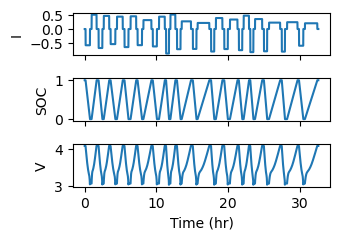

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(3.5, 2.5), sharex=True)

for ax, c, yl in zip(axs, ['current', 'soc', 'terminal_voltage'], ['I', 'SOC', 'V']):
    ax.plot(df['time'] / 3600, df[c])
    ax.set_ylabel(yl)

axs[-1].set_xlabel('Time (hr)')
fig.tight_layout()

## Make A Simple Degredation Model
Make the severity of the cycling affect the degradation potential and also splash in some randomness

In [15]:
def make_random_degradation_function():
    """Make a function which generates the capacity and resistance at each cycle

    Uses the random variation parameters defined at the beginning of the cycle

    Args:
        r0: Starting resistance
        q_t0: Starting capacity
    Return:
        Function which returns the fraction capacity loss and resistance increase as a function of cycle.
    """

    # Make the parameters for the q_t model
    cyc_q, cyc_r = knee_cycles.rvs()
    q_knee = knee_capacity.rvs()
    q_m0 = -q_knee / cyc_q
    q_mk = min(q_m0, (q_knee - 0.2) / post_knee_cycles.rvs())

    # Make the parameters for the r0 model
    r_gain = knee_resistance.rvs()
    r_m0 = r_gain / cyc_r
    r_mk = r_m0 * post_knee_resistance.rvs()

    width = knee_width.rvs()
    
    # Return the function
    def degrade_function(n: float):
        """Return the capacity and resistance as a function of cycle"""

        q_n = q_m0 * n + (q_mk - q_m0) * width * np.log((np.exp(n / width) + np.exp(cyc_q / width)) / ( 1 + np.exp(cyc_q / width)))
        r_n = r_m0 * n + (r_mk - r_m0) * width * np.log((np.exp(n / width) + np.exp(cyc_r / width)) / ( 1 + np.exp(cyc_r / width)))
        return 1 + q_n, (1 + r_n)

    return degrade_function

Text(0.5, 0, 'Cycle')

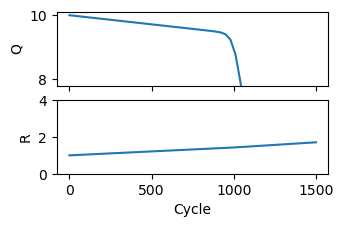

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 2.1), sharex=True)

degrade_func = make_random_degradation_function()
cycles = np.linspace(0, 1500)

cycle_q, cycle_r = degrade_func(cycles)

axs[0].plot(cycles, 10 * cycle_q)
axs[0].set_ylim(7.8, 10.1)
axs[0].set_ylabel('Q')

axs[1].plot(cycles, cycle_r)
axs[1].set_ylim(0, 4)
axs[1].set_ylabel('R')
axs[1].set_xlabel('Cycle')

Write a new simulation function which updates the ASOH at each cycle

In [17]:
def run_simulation(max_cycles: int, asoh: ECMASOH, state: ECMTransientVector, end_qt: float = 0.79, seed: int=1) -> tuple[Simulator, pd.DataFrame]:
    """Run an ECM simulation for a set number of cycles

    Args:
        num_cycles: Maximum number of cycles to run
        asoh: Initial ASOH
        state: Initial transient state
        end_qt: When to stop cycling
        seed: Random seed for the cycling protocol
    Returns:
        - Simulator object ready with history already populated
        - Actual ASOH at each frame
    """

    # Get the initial capacity and r0, use them for a cycle
    asoh = asoh.model_copy(deep=True)
    for r in ['r0.base_values', 'q_t.base_values']:
        asoh.mark_updatable(r)
    q_t0 = asoh.q_t.base_values.copy()
    r0 = asoh.r0.base_values.copy()

    # Make the degredatation function
    deg_func = make_random_degradation_function()
    
    simulator = Simulator(
        model=ECM(),
        asoh=asoh,
        initial_input=ECMInput(),
        transient_state=state.model_copy(deep=True),
        keep_history=True
    )
    
    rng = np.random.default_rng(seed)
    actual_asoh = []
    start_time = 0.
    cycle_index = [0]
    for cycle in range(max_cycles):
        actual_asoh.append(asoh.get_parameters()[0, :])

        # Run the cycle
        start_steps = len(simulator.input_history)
        for inputs in cycle_protocol(simulator.asoh, rng, start_time=start_time):
            simulator.step(inputs)
        steps_in_cycle = len(simulator.input_history) - start_steps
        cycle_index.extend([cycle] * steps_in_cycle)

        # Increment the start time used in the cycle generator
        start_time = simulator.previous_input.time[0, 0] + timestep_duration

        # Adjust the ASOH parameters, with a slight amount of noise
        
        q_factor, r_factor = degrade_func(cycle)
        if q_factor < end_qt:
            break
        asoh.q_t.base_values = q_t0 * (q_factor + rng.normal(0., 0.00001))  # Adjust by a random amount
        asoh.r0.base_values = r0 * (r_factor + rng.normal(0., 0.001))

    # Render the simulated data to a 
    dataset = simulator.to_batdata(extra_columns=True)[0]
    dataset.raw_data['cycle_number'] = cycle_index
    return dataset, pd.DataFrame(actual_asoh, columns=[f'actual_{c}' for c in asoh.expand_names(asoh.updatable_names)])

Demonstrate on a single cell

In [18]:
dataset, actual_asoh = run_simulation(20, asoh_start, state_start)

Text(0, 0.5, 'R')

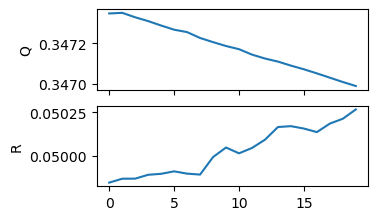

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(3.5, 2.3), sharex=True)

axs[0].plot(actual_asoh.index, actual_asoh['actual_q_t.base_values'])
axs[0].set_ylabel('Q')
axs[1].plot(actual_asoh.index, actual_asoh['actual_r0.base_values[0]'])
axs[1].set_ylabel('R')

Make a function for saving it to disk 

In [20]:
def to_hdf5(out_path, dataset: BatteryDataset, asoh: ECMASOH, cycle_stats: pd.DataFrame) -> Path:
    """Save the synthetic data to a uniquely-named data file

    Adds the ASOH parameters for the start of the simulation to the header
    
    Stores any cycle-level measurements to the 

    Args:
        data_dir: Path in which to save HDF5 files
        name: Name to use for the file
        dataset: Raw data from cycling experiment
        asoh: Input parameters
        cycle_stats: Any cycle statistics available for the cell
    Returns:
        Path to the saved file
    """

    # Convert the simulation data to BatData format then add metadata
    assert asoh.batch_size == 1, 'I have not implemented batch support'
    dataset.cycle_stats = cycle_stats
    dataset.metadata.is_measurement = False
    dataset.metadata.modeling = ModelMetadata(
        name='Moirae',
        version=moirae_version,
        type='empirical',
        models=['BatteryEquivalentCircuitModel'],
        parameters={'asoh': asoh_start}
    )

    # Make a hash based on the metadata
    dataset.to_batdata_hdf(out_path, complevel=9)

Run for a large number of iterations

In [21]:
for i in tqdm(range(64)):
    # Skip if the file already exists
    out_path = output_dir / f'bilinear-{i}.hdf5'
    if out_path.exists():
        continue
    
    # Make a new ASOH with slightly different q_t and R_0
    my_asoh = asoh_start.model_copy(deep=True)
    my_asoh.q_t.base_values *= (1 + np.random.normal(0, 0.01))
    my_asoh.r0.base_values *= (1 + np.random.normal(0, 0.01))

    # Run the cycling the save to HDF5
    dataset, actual_asoh = run_simulation(2000, my_asoh, state_start)
    to_hdf5(out_path, dataset, my_asoh, actual_asoh)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [7:16:49<00:00, 409.52s/it]
